## Lecture 7. CNN-FMNIST 
  (1) Fashion MNIST 데이터를 처리하는 CNN 모델을 만든다.\
  (2) 학습데이터에 대한 epoch에 따른 cross-entropy loss와 accuracy 그래프를 그린다.\
  (3) 테스트 데이터에 대한 인식률을 그린다.

Step 0. 설정

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn.functional as F

import random
import numpy as np

from utilities import EarlyStopping

In [3]:
L_R = 1e-3
BATCH_SIZE = 100
EPOCHS = 30

In [4]:
if torch.cuda.is_available()==True:
  DEVICE='cuda'
else:
  DEVICE='cpu'
np.random.seed(0b011011)
random.seed(0b011011)
torch.manual_seed(0b011011)
if DEVICE == 'cuda':
  torch.cuda.manual_seed_all(0b011011)


print("You are using '{}' as a device.".format(DEVICE))

You are using 'cuda' as a device.


Step 1. Data

In [5]:
train_data = datasets.FashionMNIST(
    root="F:\Python_Codes\Data_for_Practice", 
    train=True, 
    download=True, 
    transform=ToTensor()
    )



test_data= datasets.FashionMNIST(
    root="F:\Python_Codes\Data_for_Practice", 
    train=False, 
    download=True, 
    transform=ToTensor()
    )


train_data, val_data=torch.utils.data.random_split(train_data, [50000,10000])

print(test_data.data.size())

torch.Size([10000, 28, 28])


C:\ProgramData\Anaconda3\envs\pytorch_env\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
train_dataloader =DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader =DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader =DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

2. Model

In [7]:
class CNN(nn.Module):
#nn.Module을 서브클래스로 두면서 NN을 정의하고, __init__에서 NN layers을 초기화한다.
	def __init__(self, drop_prob=0.5):
		self.drop_prob=drop_prob
	#init에서는 모델을 초기화하고, 모델 구조 정의가 이루어진다.
		super(CNN, self).__init__()
		self.conv1=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2)
        )
		self.conv2=nn.Sequential(
			nn.Conv2d(32,64,kernel_size=3,stride=1, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2)
		)
		self.conv3=nn.Sequential(
			nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
		)

		self.fc1=nn.Sequential(
			nn.Linear(4*4*128,4*128),
			nn.ReLU(),
			#nn.Dropout(p=drop_prob)
		)

		self.fc2=nn.Sequential(
			nn.Linear(4*128,10)
		)
	def forward(self, x):
	#forward에서는 실행 정의가 이루어진다. 즉 NN의 결과를 계산한다.
		x=self.conv1(x)
		x=self.conv2(x)
		x=self.conv3(x)

		x=x.view(x.size(0), -1)
		x=self.fc1(x)
		x=self.fc2(x)
		return x


model=CNN().to(DEVICE)

Step 3 and 4. Loss Function and Optimization

In [8]:
loss_fn=nn.CrossEntropyLoss().to(DEVICE)
optimizer=torch.optim.Adam(model.parameters(),lr=L_R)

Train Loop, Test Loop, and Train Model

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    data_num=len(dataloader.dataset)
    batch_num=len(dataloader)
    train_loss=0
    train_correct=0

    for batchs, (X,Y) in enumerate(train_dataloader):
        optimizer.zero_grad()

        X=X.to(DEVICE)
        Y=Y.to(DEVICE)

        Y_hat=model(X)
        loss=loss_fn(Y_hat, Y)
        loss.backward()
        optimizer.step()

        train_correct+= (Y_hat.argmax(1) == Y).type(torch.float).sum().item()
        train_loss+=loss.item()

    train_loss/=batch_num
    train_acc = train_correct/data_num
    return train_loss, train_acc

In [11]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    data_num=len(dataloader.dataset)
    batch_num=len(dataloader)
    test_loss=0
    test_correct=0

    with torch.no_grad():
        for batchs, (X,Y) in enumerate(dataloader):
            X=X.to(DEVICE)
            Y=Y.to(DEVICE)

            Y_hat=model(X)
            
            loss=loss_fn(Y_hat, Y)
            test_correct+=(Y_hat.argmax(1)==Y).type(torch.float).sum().item()
            test_loss += loss.item()
    
    test_loss/=batch_num
    test_acc = test_correct/data_num

    return test_loss, test_acc

In [12]:
def train_model():
    early_stopping=EarlyStopping(patience=7, verbose=True)
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    
    exe_epoch=0

    for epoch in range(EPOCHS):
        exe_epoch+=1

        print(f"\n{epoch+1}번째 Epoch", end="  ")

        train_loss, train_acc= train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        print(f"\nTrain - avg Loss= {train_loss:>8f},  Accuracy: {(100*train_acc):>0.1f}%", end = "  ")
        
        val_loss, val_acc=test_loop(val_dataloader,model,loss_fn)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"\nVal - avg Loss= {val_loss:>8f},  Accuracy: {(100*val_acc):>0.1f}%\n", end = "  ")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early Stop!")
            break

        model.load_state_dict(torch.load('checkpoint.pt'))
    
    print("Done!")
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list, exe_epoch

In [13]:
train_loss, train_acc, val_loss, val_acc, exe_epoch = train_model()


1번째 Epoch  

C:\ProgramData\Anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train - avg Loss= 0.536882,  Accuracy: 80.2%  
Val - avg Loss= 0.401884,  Accuracy: 85.1%
  Validation loss decreased (inf --> 0.401884).  Saving model ...

2번째 Epoch  
Train - avg Loss= 0.321679,  Accuracy: 88.1%  
Val - avg Loss= 0.314444,  Accuracy: 88.3%
  Validation loss decreased (0.401884 --> 0.314444).  Saving model ...

3번째 Epoch  
Train - avg Loss= 0.266188,  Accuracy: 90.1%  
Val - avg Loss= 0.271758,  Accuracy: 90.4%
  Validation loss decreased (0.314444 --> 0.271758).  Saving model ...

4번째 Epoch  
Train - avg Loss= 0.236982,  Accuracy: 91.1%  
Val - avg Loss= 0.246107,  Accuracy: 90.7%
  Validation loss decreased (0.271758 --> 0.246107).  Saving model ...

5번째 Epoch  
Train - avg Loss= 0.210245,  Accuracy: 92.1%  
Val - avg Loss= 0.225042,  Accuracy: 91.5%
  Validation loss decreased (0.246107 --> 0.225042).  Saving model ...

6번째 Epoch  
Train - avg Loss= 0.186769,  Accuracy: 93.0%  
Val - avg Loss= 0.226992,  Accuracy: 91.6%
  EarlyStopping counter: 1 out of 7

7번째 Epo

Figure

In [14]:
print(train_loss)

[0.5368823644518852, 0.3216794902384281, 0.2661876434087753, 0.23698187732696532, 0.21024542793631554, 0.1867691238671541, 0.1872936983630061, 0.16617251546680928, 0.16684515356272459, 0.16572971933335065, 0.16698682520538569, 0.16871807624399662, 0.16866076493263243, 0.16801577954739333]


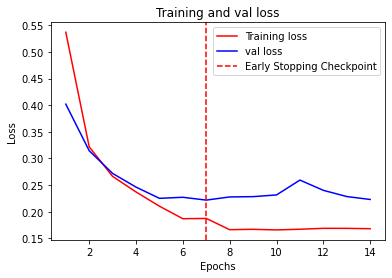

In [15]:
epochs=np.arange(1,exe_epoch+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='val loss')

minposs = val_loss.index(min(val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.title('Training and val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

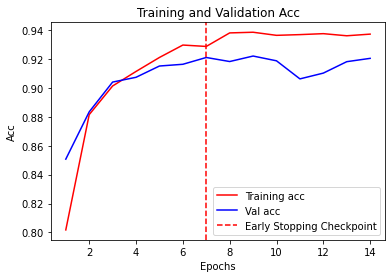

In [16]:
plt.clf()   # 그래프를 초기화합니다
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Val acc')

minposs = val_loss.index(min(val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

5. Test

In [17]:
test_loss, test_acc= test_loop(test_dataloader, model, loss_fn)
print(f"\nTest - avg Loss= {test_loss:>8f},  Accuracy: {(100*test_acc):>0.1f}%\n", end = "  ")


Test - avg Loss= 0.246802,  Accuracy: 91.1%
  

torch.return_types.max(
values=tensor([11.3883,  7.9116, 17.2209, 17.7672,  4.6593, 15.3688,  5.6697,  6.1884,
         8.5687, 11.6635,  5.9066,  8.2083,  4.9846,  8.8291,  6.4513, 16.0015,
         6.7252,  3.8893, 11.2751,  5.1285,  7.5273,  6.9831,  8.5603, 13.3241,
        17.8502,  3.6971,  3.9410,  3.3473,  9.7860,  3.1062, 18.4178, 16.1364,
         4.2234,  4.8943, 13.6975,  6.2528, 11.9699,  6.5117,  7.9600, 13.4770,
         3.7328, 16.8395,  1.8673,  5.7337,  5.4313,  7.8127,  4.8649, 10.5114,
         4.2839,  2.0143,  6.1974,  3.3312, 10.6644,  9.4464,  7.1371,  7.1381,
        12.9096,  4.6033, 11.5839,  9.6677,  8.2596,  6.8817, 13.0352, 12.8061,
        19.9596, 14.0592,  1.4900,  3.4390,  6.8287, 17.4170,  7.3440,  5.2574,
         7.7140,  1.9603,  6.3661,  6.0638, 20.5243,  7.2252, 11.7020,  7.4834,
        10.0440, 13.4788, 16.2120, 13.1524, 15.3945,  6.0812,  5.8685,  9.6839,
         6.7748,  3.6381, 15.9972,  9.0322,  5.1077, 10.1571, 15.6064,  8.2445,
         

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_22316/3139184142.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


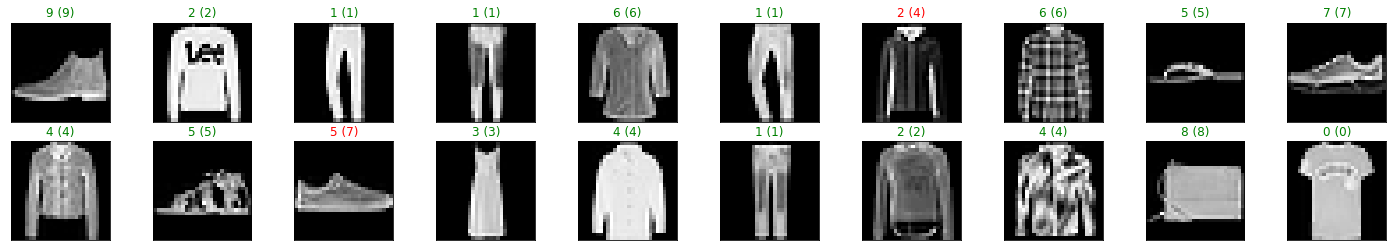

In [19]:
# obtain one batch of test images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

output = model(images.to(DEVICE))

_, preds = torch.max(output, 1)
#뒤에 거가 indices

print(torch.max(output,1))
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

